*LAB 04*

Train an RBM on any dataset.

Extract meaningful features from input data.

Use extracted features for classification.

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.46s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.25s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.88, time = 0.24s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.25s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.79, time = 0.24s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -20.96, time = 0.25s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.88, time = 0.24s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.50, time = 0.24s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.34, time = 0.24s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.21, time = 0.26s
Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18       174
           1       0.00      0.00      0.00       184
           2       0.00      0.00      0.00       166
           3       0.00      0.00      0.00       19

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

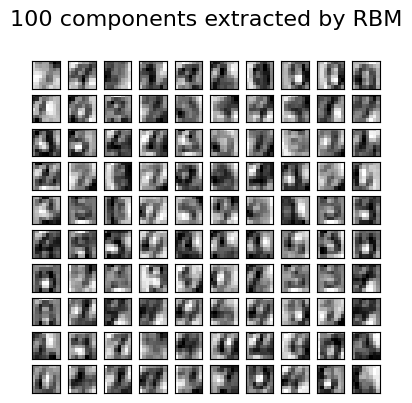

In [2]:
import numpy as np
from scipy.ndimage import convolve

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale


def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate(
        [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors]
    )
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1))  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn import linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm), ("logistic", logistic)])

from sklearn.base import clone

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10

# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

from sklearn import metrics

Y_pred = rbm_features_classifier.predict(X_test)
print(
    "Logistic regression using RBM features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

Y_pred = raw_pixel_classifier.predict(X_test)
print(
    "Logistic regression using raw pixel features:\n%s\n"
    % (metrics.classification_report(Y_test, Y_pred))
)

import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

Epoch 1, Loss: 0.0133
Epoch 2, Loss: 0.0133
Epoch 3, Loss: 0.0133
Epoch 4, Loss: 0.0133
Epoch 5, Loss: 0.0133
Epoch 6, Loss: 0.0133
Epoch 7, Loss: 0.0133
Epoch 8, Loss: 0.0133
Epoch 9, Loss: 0.0133
Epoch 10, Loss: 0.0133
Classification Accuracy: 0.1143


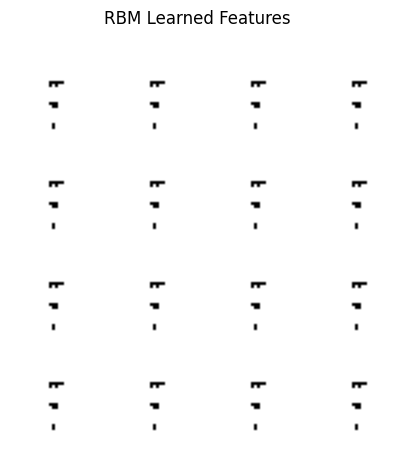

In [3]:
import numpy as np
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.astype(np.float32), mnist.target.astype(np.int64)

# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class RBM:
    def __init__(self, visible_units, hidden_units, learning_rate=0.01, epochs=10, batch_size=64):
        self.visible_units = visible_units
        self.hidden_units = hidden_units
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size

        # Initialize weights and biases
        self.weights = tf.Variable(tf.random.normal([self.visible_units, self.hidden_units], stddev=0.01))
        self.hidden_bias = tf.Variable(tf.zeros([self.hidden_units]))
        self.visible_bias = tf.Variable(tf.zeros([self.visible_units]))

    def sigmoid(self, x):
        return tf.nn.sigmoid(x)

    def sample(self, probabilities):
        return tf.nn.relu(tf.sign(probabilities - tf.random.uniform(tf.shape(probabilities))))

    def forward(self, v):
        h_prob = self.sigmoid(tf.matmul(v, self.weights) + self.hidden_bias)
        h_sample = self.sample(h_prob)
        return h_prob, h_sample

    def backward(self, h):
        v_prob = self.sigmoid(tf.matmul(h, tf.transpose(self.weights)) + self.visible_bias)
        return v_prob

    def train(self, data):
        dataset = tf.data.Dataset.from_tensor_slices(data).batch(self.batch_size)

        optimizer = tf.optimizers.Adam(self.learning_rate)

        for epoch in range(self.epochs):
            total_loss = 0
            for batch in dataset:
                with tf.GradientTape() as tape:
                    # Positive phase
                    h_prob, h_sample = self.forward(batch)
                    pos_associations = tf.matmul(tf.transpose(batch), h_prob)

                    # Negative phase
                    v_reconstructed = self.backward(h_sample)
                    h_reconstructed, _ = self.forward(v_reconstructed)
                    neg_associations = tf.matmul(tf.transpose(v_reconstructed), h_reconstructed)

                    # Compute gradients
                    weight_gradient = (pos_associations - neg_associations) / self.batch_size
                    visible_bias_gradient = tf.reduce_mean(batch - v_reconstructed, axis=0)
                    hidden_bias_gradient = tf.reduce_mean(h_prob - h_reconstructed, axis=0)

                    loss = tf.reduce_mean(tf.square(batch - v_reconstructed))
                    total_loss += loss.numpy()

                # Update weights and biases
                gradients = [weight_gradient, hidden_bias_gradient, visible_bias_gradient]
                optimizer.apply_gradients(zip(gradients, [self.weights, self.hidden_bias, self.visible_bias]))

            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(data):.4f}")

    def transform(self, data):
        h_prob, _ = self.forward(data)
        return h_prob.numpy()

# Initialize and train the RBM
rbm = RBM(visible_units=784, hidden_units=128, learning_rate=0.01, epochs=10, batch_size=64)
rbm.train(X_train)

# Extract features from training and test data
X_train_features = rbm.transform(X_train)
X_test_features = rbm.transform(X_test) # Train a Logistic Regression model on extracted features
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_features, y_train)

# Make predictions
y_pred = clf.predict(X_test_features)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification Accuracy: {accuracy:.4f}")
# Visualize first 16 feature detectors (weights)
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(rbm.weights.numpy()[:, i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle("RBM Learned Features")
plt.show()
